# Tensorflow & ONNX

In this tutorial, we investigate a conversion of the [Tensorflow (Keras)](https://www.tensorflow.org/) model to the [ONNX](https://onnx.ai/) format and compare both models. For performing experiments, we selected the "adult" classification data set. It contains a combination of numeric and categorical features.

But before we start, let's set up our working environment.

In [47]:
# Let's make a temporary directory for the artifact created by this notebook.
import os
if not os.path.exists('tmp'):
    os.makedirs('tmp')

## Prepare Dataset

For creating ML models we loaded the "adult" dataset and selected the following features:

| Feature      | Kind        | Type    | Enforce(*) |
| -------------| ----------- | ------- | ---------- |
| sepal_length | numeric     | float32 | yes        |
| sepal_width  | numeric     | float32 | yes        |
| petal_length | numeric     | float32 | yes        |
| petal_width  | numeric     | float32 | yes        |

(*) We will need to enforce types for features whose original types have been detected differently from our expectations.

We forced the conversion of all numeric fields "sepal_length", "sepal_width", "petal_length" and "petal_width" from **float64** to **float32**. For our experiments, we do not need this precision.

In [49]:
import numpy as np
from utils import load_dataset

# Sets the loading dataset name.
dataset_name = 'adult'

# Loads the dataset.
dataset = load_dataset(dataset_name)

dataset.X.dtypes

# Selects "float32" for the numeric columns.
# dataset['sepal_length'] = dataset['sepal_length'].astype(np.float32)
# dataset['sepal_width'] = dataset['sepal_width'].astype(np.float32)
# dataset['petal_length'] = dataset['petal_length'].astype(np.float32)
# dataset['petal_length'] = dataset['petal_length'].astype(np.float32)

# Splits data into training (2/3) and test (1/3).
# train, test = dataset.train_test_split()

# print('Loaded "%s" datase:' % dataset_name)
# print('   - number of training samples: %d' % len(train))
# print('   - number of test samples:     %d' % len(test))


Age               int64
fnlwgt            int64
EducationNum      int64
CapitalGain       int64
CapitalLoss       int64
HoursPerWeek      int64
WorkClass        object
Education        object
MaritalStatus    object
Occupation       object
Relationship     object
Race             object
Gender           object
NativeCountry    object
dtype: object

In [52]:
from utils import create_preprocessor
from sklearn.model_selection import train_test_split

# Creates a data preprocessing pipeline.
preprocessor = create_preprocessor(dataset)

X = preprocessor.fit_transform(dataset.X).toarray().astype(np.float32)
y = np.where(dataset.y == '>50K',1,0).astype(np.int32)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42
)


## Train & Test XGBoost Model

First, we need to define the XGBoost classifier.

In [55]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint

# Builds models in Keras using the Sequential interface.
model = Sequential()

# Adds a first Dense supplying the input shape of your data.
model.add(Dense(100, input_shape=[X_train.shape[1]], activation='relu'))

# Adding more Dense layers to learn more complex relationships. 
# We will Dropout layers to prevent model overfitting.
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))

# Lets use Last Dense layer with the Sigmoid activation (due to the  binary 
# classification)
model.add(Dense(1, activation='sigmoid'))

#  Compiles the model and prits its summary.
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 100)               10900     
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                

Then we create a training pipeline that combines data preprocessor and classifier. The data preprocessor provides steps for handling numeric features. For more information, please review the utility function **create_preprocessor** in the **utils** module.

**Please note**, our goal for this tutorial is not to create the best classification model for the "iris" dataset. So we will not focus on picking the best feature and optimizing hyperparameters of the different classifiers. Our goal is to learn more about ONNX! :wink:

The trained ML model showed an accuracy of **100%**. 

In [62]:
from sklearn.metrics import accuracy_score

# Trains the Tenserflow (Keras) model.
model.fit(X_train, y_train, batch_size=64, epochs=20, verbose=1, 
          validation_data=(X_test,y_test))

# Uses the model for scoring.
y_tensorflow_probas = model.predict(X_test)                              # collects the prediction probabilities;
y_tensorflow_pred = np.where(y_tensorflow_probas > 0.5, 1, 0).flatten()  # collects the predicted labels;

# Just for convenience name the test.y labels as the ground truth.
y_true = y_test

# Computes the accuracy score.
tensorflow_accuracy = accuracy_score(y_true, y_tensorflow_pred)
print('The model accuracy: %.2f' % tensorflow_accuracy)

The model accuracy: 0.85


## Convert Model To ONNX

Next, we need to convert the XGBoost model into the ONNX format and serialize it to the file. The conversion process is done by the **convert_sklearn** function. However, before calling this function, we need to register the [XGBoost convertor](https://github.com/onnx/onnxmltools). The rest of the process is the same as for [SKLearn notebook](onnx_sklearn.ipynb).

One important aspect you need to focus on is setting correct input types. To do that we provided the utility function **get_onnx_input_type** defined in the **utils** module. It takes the training dataset and uses it to guess ONNX input types. This function has meant to be generic, so we can reuse it in different notebooks. In practice, you can optimize the input types to feet your data.

In [63]:
from tensorflow import keras
import tf2onnx.convert

model.save('tmp/xxx.h5', overwrite=True, include_optimizer=False, save_format='tf')
model = keras.models.load_model('tmp/xxx.h5')
onnx_model, _ = tf2onnx.convert.from_keras(model)


# # Converts the model to the ONNX format.
onnx_filename = 'model.onnx'
# # onnx_model = convert_keras(model, 'aaa')

# Serializes the ONNX model to the file.
with open(os.path.join('tmp', onnx_filename), "wb") as f:
    f.write(onnx_model.SerializeToString())
    print('The ONNX model has been successfully saved in "model.onnx" file.')

The ONNX model has been successfully saved in "model.onnx" file.


2021-09-08 14:21:20.685163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 14:21:20.685483: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2021-09-08 14:21:20.685542: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2021-09-08 14:21:20.685856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-08 14:21:20.686086: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and 

## Load & Test ONNX Model

To load the model, we just need to specify its file name in the runtime. 

```Python
sess = rt.InferenceSession(os.path.join('tmp', onnx_filename))
```

Unfortunately, we cannot use the test Pandas data frame directly for inference. The data entering the ONNX model has to be transformed in a slightly different format. To perform this transformation we are using the **get_onnx_input_data** function defined in the **utils** module. This function converts the Pandas data frame:

```
     sepal_length  sepal_width  petal_length  petal_width
73            6.1          2.8           4.7          1.2
18            5.7          3.8           1.7          0.3
118           7.7          2.6           6.9          2.3
78            6.0          2.9           4.5          1.5
76            6.8          2.8           4.8          1.4
..            ...          ...           ...          ...
81            5.5          2.4           3.7          1.0
133           6.3          2.8           5.1          1.5
137           6.4          3.1           5.5          1.8
75            6.6          3.0           4.4          1.4
109           7.2          3.6           6.1          2.5
```

in the following dictionary:

```
{
    'sepal_length': array([
        [6.1],
        [5.7],
        [7.7],
        [6. ],
        [6.8],
        ...
        [7.2]], dtype=float32), 
    'sepal_width': array([
        [[2.8],
        [3.8],
        [2.6],
        [2.9],
        [2.8],
        ...
        [3.6]], dtype=float32),
    'petal_length': array([
        [4.7],
        [1.7],
        [6.9],
        [4.5],
        [4.8],
        ...
        [6.1]], dtype=float32),
    'petal_width': array(
        [[1.2],
        [0.3],
        [2.3],
        [1.5],
        [1.4],
        ...
        [2.5]], dtype=float32)
}
```

The ONNX model uses this dictionary for inference. From the experiment, we got the accuracy of the ONNX model 100%, which is the same as the original XGBoost model. So we can conclude that both models have the same performance.

In [69]:
import onnxruntime as rt

sess = rt.InferenceSession(os.path.join('tmp', onnx_filename))
X_test = X_test.astype(np.float32)

# feed = dict([(input.name, X_test[:,n]) for n, input in enumerate(sess.get_inputs())])
# print(feed)


feed = {sess.get_inputs()[0].name:X_test}

y_onnx_probas = sess.run(None, feed)
y_onnx_pred = np.where(y_onnx_probas[0] > 0.5, 1, 0)

onnx_accuracy = accuracy_score(y_true, y_onnx_pred)
print('The ONNX model accuracy: %.2f' % onnx_accuracy)

The ONNX model accuracy: 0.85


## Compare XGBoost & ONNX Models 

Even we did not detect any difference between XGBoost and ONNX models' accuracies, let's visualize the confusion matrix. In this confusion matrix, we will consider the predictions generated by the XGBoost model as ground truth (GT).

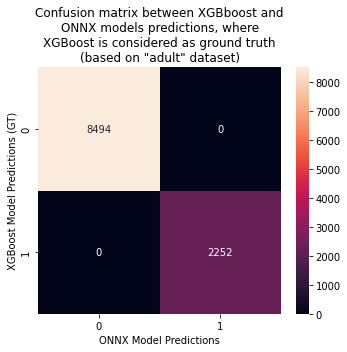

In [70]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

# Creates the confusion matrix.
cm = confusion_matrix(y_tensorflow_pred, y_onnx_pred)
df_cm = pd.DataFrame(cm, range(2), range(2))

# Makes a confusion matrix plot.
fig, ax = plt.subplots(figsize=(5,5))
sn.heatmap(df_cm, annot=True, fmt='d', ax=ax)
ax.set_title( f'Confusion matrix between XGBboost and\nONNX models predictions, where\nXGBoost is considered as ground truth\n(based on "{dataset_name}" dataset)' )
ax.set_xlabel("ONNX Model Predictions")
ax.set_ylabel("XGBoost Model Predictions (GT)")
plt.tight_layout()

Despite the same accuracy, we expect some differences in prediction probabilities. To visualize these differences, we substruct  ONNX probabilities from XGBoost probabilities and then plot the distribution of differences using a box plot.

In [ ]:
print(dataset.y)

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object


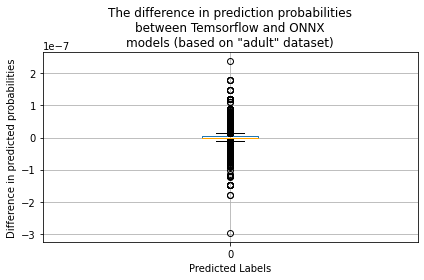

In [79]:
from sklearn.metrics import r2_score


# Convert XGBoost and ONNX probabilities into Pandas data frame. This will
# help us to perform mathematical operations later.
df_xgboost_probas = pd.DataFrame(y_tensorflow_probas, columns=[0])
df_onnx_probas = pd.DataFrame(y_onnx_probas[0], columns=[0])

# Computes a difference between XGBoost and ONNX probabilities.
df_diff = df_xgboost_probas - df_onnx_probas

# Makes a Box plot.
poxplot = df_diff.boxplot(color={'medians': 'orange'})
plt.title( f'The difference in prediction probabilities\nbetween Temsorflow and ONNX\nmodels (based on "{dataset_name}" dataset)' )
plt.xlabel("Predicted Labels")
plt.ylabel("Difference in predicted probabilities")
plt.tight_layout()
plt.savefig(os.path.join('tmp', f'diff_xgboost.jpg'))